In [ ]:
prob_map 经过后处理得到 inst 结果


In [1]:
from matplotlib import pyplot as plt

import sys
sys.path.append("/root/autodl-tmp/pannuke_app/")
# 得到每张图片的预测概率和label， 下一步是利用后处理得到 inst_map.
import numpy as np
import pandas as pd
from src.evaluation.post_proc import (
    dynamic_watershed_alias,remove_small_objects
) 
from src.evaluation import post_proc

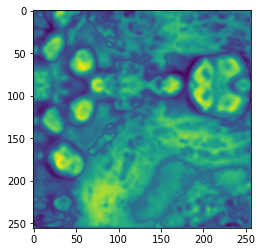

In [32]:
prob_map_path = "/root/autodl-tmp/pannuke_app/projects/patched_consep/unet/predict/prob_map/test_1_001.npy"
prob_map = np.load(prob_map_path)
plt.imshow(prob_map)

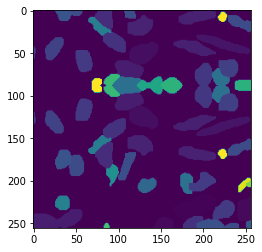

In [33]:
real_path = "/root/autodl-tmp/pannuke_app/projects/patched_consep/training_data/test/inst/test_1_001.npy"
real_inst = np.load(real_path)
plt.imshow(real_inst)

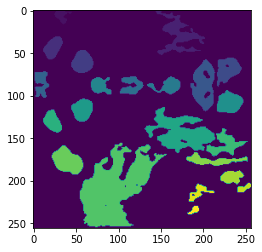

In [46]:
x = post_proc.dynamic_watershed_alias(prob_map, lamb=10, p_thresh=0.6, min_size=50, mode='prob')
# unit = np.where(x>0, 0.99, 0)
plt.imshow(x)

In [9]:
unit = np.where(x>0, 0.99, 0)

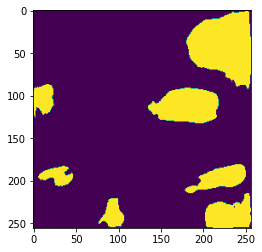

In [10]:
plt.imshow(unit)

In [11]:
y = post_proc.dynamic_watershed_alias(unit, lamb=20, p_thresh=0.95, min_size=300, mode='prob')

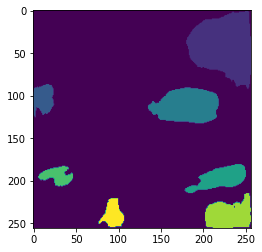

In [12]:
plt.imshow(y)

In [6]:
prob_map_path = "/root/autodl-tmp/pannuke_app/projects/pannuke/unet/predict/prob_map/test_0.npy"
prob_map = np.load(prob_map_path)
# plt.imshow(prob_map)
res = dynamic_watershed_alias(prob_map, lamb=20, p_thresh=0.95, min_size=300, mode='prob')

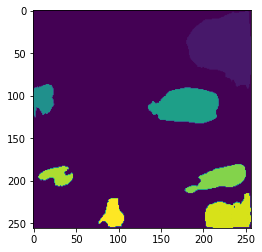

In [30]:
plt.imshow(res)

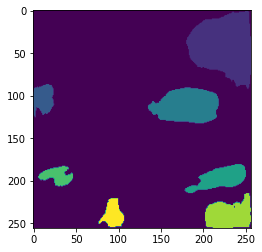

In [15]:
ar_label = arrange_label(res)
plt.imshow(ar_label)

(array([13941.,  4542.,  3985.,  4734.,  4311.,  4164.,  3562.,  4485.,
         6607., 15205.]),
 array([0.2320415 , 0.30879214, 0.38554278, 0.46229342, 0.5390441 ,
        0.6157947 , 0.69254535, 0.769296  , 0.8460466 , 0.92279726,
        0.9995479 ], dtype=float32),
 <BarContainer object of 10 artists>)

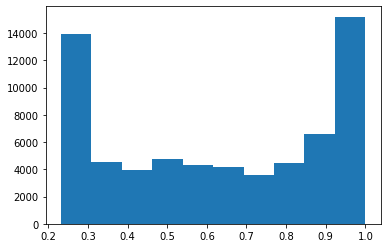

In [27]:
plt.hist(prob_map.ravel())

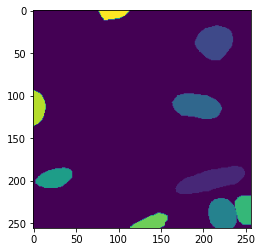

In [8]:
inst_path = "/root/autodl-tmp/pannuke_app/datasets/processed/PanNuke/test/inst/test_0.npy"
inst = np.load(inst_path)
plt.imshow(inst)


In [44]:
from src.evaluation.stats_utils import get_fast_aji, get_fast_dice_2

In [40]:
np.unique(arrange_label(pred_new))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [38]:
np.unique(pred_new)

array([ 0,  1,  2, 11, 12, 18, 19, 20, 21])

In [45]:
get_fast_dice_2(inst, arrange_label(pred_new))

0.572414968885858

In [43]:
(inst, arrange_label(pred_new))

NameError: name 'get_fast_dice2' is not defined

In [24]:
import cv2
import numpy as np
from skimage import img_as_float, img_as_ubyte
from skimage.measure import label
from skimage.morphology import (
    dilation,
    disk,
    erosion,
    reconstruction,
    remove_small_objects,
    square,
)
from skimage.segmentation import watershed


def prepare_prob(img, convertuint8=True, inverse=True):
    """
    Prepares the prob image for post-processing, it can convert from
    float -> to uint8 and it can inverse it if needed.
    """
    if convertuint8:
        img = img_as_ubyte(img)
    if inverse:
        img = 255 - img
    return img


def h_reconstruction_erosion(prob_img, h):
    """
    Performs a H minimma reconstruction via an erosion method.
    """

    def making_top_mask(x, lamb=h):
        return min(255, x + lamb)

    f = np.vectorize(making_top_mask)
    shift_prob_img = f(prob_img)

    seed = shift_prob_img
    mask = prob_img
    recons = reconstruction(seed, mask, method="erosion").astype(np.dtype("ubyte"))
    return recons


def find_maxima(img, convertuint8=False, inverse=False, mask=None):
    """
    Finds all local maxima from 2D image.
    """
    img = prepare_prob(img, convertuint8=convertuint8, inverse=inverse)
    recons = h_reconstruction_erosion(img, 1)
    if mask is None:
        return recons - img
    else:
        res = recons - img
        res[mask == 0] = 0
        return res


def get_contours(img):
    """
    Returns only the contours of the image.
    The image has to be a binary image
    """
    img[img > 0] = 1
    return dilation(img, disk(2)) - erosion(img, disk(2))


def generate_wsl(ws):
    """
    Generates watershed line that correspond to areas of touching objects.
    """
    se = square(3)
    ero = ws.copy()
    ero[ero == 0] = ero.max() + 1
    ero = erosion(ero, se)
    ero[ws == 0] = 0

    grad = dilation(ws, se) - ero
    grad[ws == 0] = 0
    grad[grad > 0] = 255
    grad = grad.astype(np.uint8)
    return grad


def arrange_label(mat):
    """
    Arrange label image as to effectively put background to 0.
    """
    val, counts = np.unique(mat, return_counts=True)
    background_val = val[np.argmax(counts)]
    mat = label(mat, background=background_val)
    if np.min(mat) < 0:
        mat += np.min(mat)
        mat = arrange_label(mat)
    return mat


def dynamic_watershed_alias(p_img, lamb=8, p_thresh=0.9,min_size=10, mode="dist"):
    """
    Applies our dynamic watershed to 2D prob/dist image.
    """
    b_img = (p_img > p_thresh) + 0
    if mode == "prob":
        Probs_inv = prepare_prob(p_img)
    else:
        # 如果预测的是dist， 则不进行 img_as_ubyte 的处理么？
        Probs_inv = p_img

    Hrecons = h_reconstruction_erosion(Probs_inv, lamb)
    markers_Probs_inv = find_maxima(Hrecons, mask=b_img)
    markers_Probs_inv = label(markers_Probs_inv)
    ws_labels = watershed(Hrecons, markers_Probs_inv, mask=b_img)
    ar_label = arrange_label(ws_labels)
    # TODO: test 是否需要加
    ar_label = remove_small_objects(ar_label, min_size=min_size, connectivity=1)
    wsl = generate_wsl(ar_label)
    ar_label[wsl > 0] = 0

    return ar_label


def post_process(prob_image, param=7, thresh=0.5, mode="dist"):
    """
    Perform dynamic_watershed_alias with some default parameters.
    """
    segmentation_mask = dynamic_watershed_alias(prob_image, param, thresh, mode)
    return segmentation_mask


# if __name__ == "__main__":
#     ma = cv2.imread(
#         "/root/autodl-tmp/com_models/DIST/datafolder/TNBC_NucleiSegmentation/GT_01/\
#         01_1.png",
#         0,
#     )
#     mask = img_as_float(ma)
#     post_process(mask)


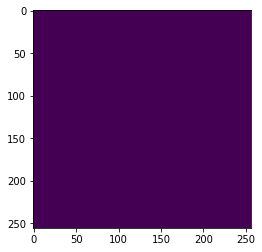

In [4]:
pred_path = "/root/autodl-tmp/pannuke_app/projects/patched_consep/unet/predict/inst/test_1_000.npy"
pred = np.load(pred_path)
plt.imshow(pred)

In [20]:
import cv2
import numpy

# img = cv2.imread("coins.jpg")
# cv2.imshow("img", img)
img = img

# 1.图像二值化
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [22]:
gray.shape

(256, 256)

In [21]:
inst.shape

(256, 256)

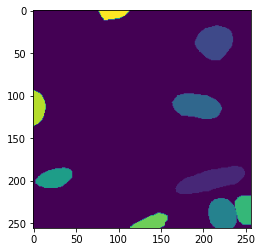

In [24]:
plt.imshow(inst)

In [52]:
import cv2
import numpy as np

def dilation_erosion_reconstruction(mask):
    kernel = numpy.ones((3, 3), dtype=numpy.uint8)
    marker = cv2.dilate(mask, kernel, iterations=2)
    reconstructed = cv2.erode(marker, kernel, iterations=2)
    return reconstructed

In [62]:
b_img = (prob_map > 0.8)
pred_prob(b_img)
r = dilation_erosion_reconstruction()

TypeError: 'numpy.ndarray' object is not callable

In [57]:
from collections import Counter

In [58]:
Counter(pred_prob.ravel().tolist())

Counter({124: 246,
         113: 184,
         130: 232,
         127: 272,
         131: 258,
         134: 251,
         141: 226,
         149: 205,
         150: 200,
         145: 214,
         132: 199,
         122: 195,
         112: 223,
         103: 212,
         99: 220,
         100: 225,
         101: 198,
         106: 181,
         111: 202,
         119: 236,
         125: 261,
         128: 268,
         114: 222,
         121: 235,
         129: 245,
         138: 231,
         153: 219,
         158: 241,
         161: 241,
         163: 232,
         164: 238,
         165: 221,
         166: 198,
         168: 235,
         169: 225,
         167: 200,
         173: 196,
         172: 210,
         156: 223,
         147: 208,
         117: 190,
         123: 243,
         148: 196,
         151: 232,
         154: 223,
         175: 182,
         184: 193,
         187: 180,
         191: 179,
         196: 189,
         201: 202,
         207: 244,
         212:

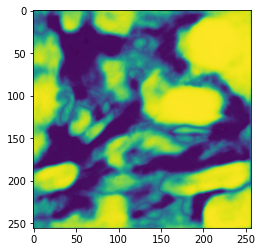

In [55]:

plt.imshow(pred_prob)

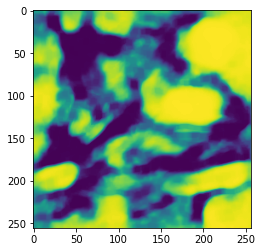

In [54]:
plt.imshow(r)

In [34]:
pred_prob = prepare_prob(prob_map, inverse=False)

In [35]:
gray = pred_prob.astype('uint8')
ret, thresh = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

In [40]:
from skimage.segmentation import watershed

In [38]:
# 2.噪声去除
kernel = numpy.ones((3, 3), dtype=numpy.uint8)
open = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 3.确定背景区域
sure_bg = cv2.dilate(open, kernel, iterations=3)

# 4.寻找前景区域
dist_transform = cv2.distanceTransform(open, 1, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)

# 5.找到未知区域
sure_fg = numpy.uint8(sure_fg)
unknow = cv2.subtract(sure_bg, sure_fg)

# 6.类别标记
ret, markers = cv2.connectedComponents(sure_fg)
# 为所有的标记加1，保证背景是0而不是1
markers = markers + 1
# 现在让所有的未知区域为0
markers[unknow == 255] = 0

# 7.分水岭算法
markers = cv2.watershed(pred_prob, markers)
pred_prob[markers == -1] = (0, 0, 255)

# cv2.imshow("gray", gray)
# cv2.imshow("thresh", thresh)
# cv2.imshow("open", open)
# cv2.imshow("sure_bg", sure_bg)
# cv2.imshow("sure_fg", sure_fg)
# cv2.imshow("unknow", unknow)
# cv2.imshow("img_watershed", img)
# cv2.waitKey(0)
# cv2.destroyWindow()

error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


In [ ]:
ws_labels = watershed(Hrecons, markers_Probs_inv, mask=b_img)

In [42]:
b_img = (prob_map > 0.8)

In [48]:
x = watershed(pred_prob, markers, mask=b_img)

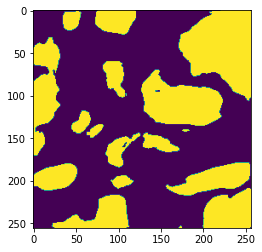

In [49]:
plt.imshow(x)

In [5]:
import cv2

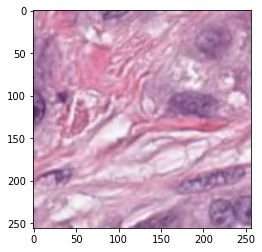

In [6]:
img_path = "/root/autodl-tmp/pannuke_app/datasets/processed/PanNuke/test/imgs/test_0.png"
img = cv2.imread(img_path)
plt.imshow(img)

In [ ]:
dynamic_watershed_alias()